# 并发

In [1]:
import time
import asyncio
import functools

def time_consume(f):
    @functools.wraps(f)
    def wrapper(concurrency, *args, **kwargs):
        start_tm = time.time()
        ret = f(*args, **kwargs)
        print(f'{f.__name__} concurrency {concurrency} elapse {int(time.time() - start_tm)} seconds')
        return ret
    
    return wrapper

In [2]:
@time_consume
def dummy(**kwargs):
    time.sleep(1)

In [3]:
dummy(concurrency=10)

dummy concurrency 10 elapse 1 seconds


## 多线程

In [4]:
# encoding: utf8

import os
import re
import time
import queue
import requests
import threading

pdf_pattern = re.compile(">(\d+.+\.pdf)<")

home_url = 'https://courses.cs.washington.edu/courses/cse326/08sp/lectures/markup/'


def mt_download(url: str):
    """Multi thread download"""
    resp = requests.get(url)
    return resp.content


def mt_worker(i: int, q: queue.Queue):
    while not q.empty():
        url = q.get_nowait()
        if url is queue.Empty:
            return

        mt_download(url)
        q.task_done()


@time_consume
def mt_main(concurrency: int = 2):
    content = mt_download(home_url)
    content = content.decode()

    q = queue.Queue()
    for pdf in pdf_pattern.findall(content):
        url = os.path.join(home_url, pdf)
        q.put_nowait(url)

    tasks = []
    for i in range(concurrency):
        task = threading.Thread(target=mt_worker, args=(i, q))
        task.start()
        tasks.append(task)

    for task in tasks:
        task.join()

## 多进程

In [5]:
# encoding: utf8

import os
import re
import time
import queue
import requests
import multiprocessing as mp


pdf_pattern = re.compile(">(\d+.+\.pdf)<")

home_url = 'https://courses.cs.washington.edu/courses/cse326/08sp/lectures/markup/'


def mp_download(url: str):
    resp = requests.get(url)
    return resp.content


def mp_worker(i: int, q: mp.Queue):
    while not q.empty():
        url = q.get_nowait()
        if url is queue.Empty:
            return

        mp_download(url)


@time_consume
def mp_main(concurrency: int = 2):
    q = mp.Queue()

    content = mp_download(home_url)
    content = content.decode()

    for pdf in pdf_pattern.findall(content):
        url = os.path.join(home_url, pdf)
        q.put(url)

    tasks = []
    for i in range(concurrency):
        p = mp.Process(target=mp_worker, args=(i, q))
        p.start()
        tasks.append(p)

    for p in tasks:
        p.join()

## 协程

In [6]:

# encoding: utf8

import os
import re
import time
import asyncio
import aiohttp
import aiofiles

pdf_pattern = re.compile(">(\d+.+\.pdf)<")

home_url = 'https://courses.cs.washington.edu/courses/cse326/08sp/lectures/markup/'


async def aio_download(url: str):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as resp:
            content = await resp.read()
            return content


async def aio_main():
    content = await aio_download(home_url)
    content = content.decode()

    tasks = []
    for pdf in pdf_pattern.findall(content):
        url = os.path.join(home_url, pdf)
        task = asyncio.create_task(aio_download(url))
        tasks.append(task)

    await asyncio.gather(*tasks)

## 结论

In [7]:
start_tm = time.time()
await aio_main()
finish_tm = time.time()
print(f'coroutine concurrency elapse {int(finish_tm - start_tm)} seconds')

coroutine concurrency elapse 8 seconds


In [8]:
aio_tm = finish_tm - start_tm

In [9]:
concurrences = [2, 4, 8, 12]
mt_concurrency = []
mp_concurrency = []

In [11]:
for concurrency in concurrences:
    start_tm = time.time()
    mt_main(concurrency)
    finish_tm =time.time()
    mt_concurrency.append( int(finish_tm - start_tm))

    start_tm = time.time()
    mp_main(concurrency)
    finish_tm = time.time()
    mp_concurrency.append(int(finish_tm - start_tm))

mt_main concurrency 2 elapse 39 seconds
mp_main concurrency 2 elapse 47 seconds
mt_main concurrency 4 elapse 49 seconds
mp_main concurrency 4 elapse 49 seconds
mt_main concurrency 8 elapse 42 seconds
mp_main concurrency 8 elapse 48 seconds
mt_main concurrency 12 elapse 56 seconds
mp_main concurrency 12 elapse 53 seconds


In [ ]:
import matplotlib.pyplot as plt

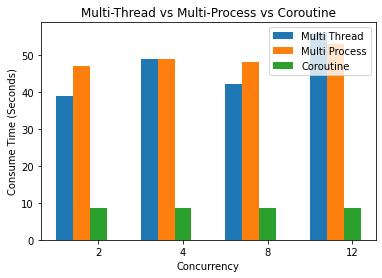

In [22]:
width = 0.2

# 多线程
x = list(range(len(concurrences)))
plt.bar(x, mt_concurrency, width=width, label='Multi Thread')

# 多进程
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, mp_concurrency, width=width, label='Multi Process')

# 协程
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, [aio_tm] * len(x), width=width, label='Coroutine', tick_label=concurrences)

plt.xlabel('Concurrency')
plt.ylabel('Consume Time (Seconds)')
plt.title('Multi-Thread vs Multi-Process vs Coroutine')
plt.legend()
plt.show()